# Analyzing download speeds in All U.S. counties using Python

In this tutorial I will talk about how to:

    * Download the Ookla open dataset
    * Geocode the tiles to counties
    * Make a table of the top and bottom 20 counties by download speed
    * Map the counties

There are two main ways to join these tiles to another geographic dataset: quadkeys and spatial joins. This tutorial will use the spatial join approach.

In [1]:
%matplotlib inline

from datetime import datetime

import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from shapely.geometry import Point
from adjustText import adjust_text
from pyathena import connect
import contextily as ctx
import time
import boto3
import pandas as pd
import io

#### Get data from athena

In [2]:
class QueryAthena:

    def __init__(self, query, database):
        self.database = database
        self.folder = 'athena-output/'
        self.bucket = 'uiuc-research-paper'
        self.s3_output =  's3://' + self.bucket + '/' + self.folder
        self.region_name = 'us-east-2'
        self.query = query

    def load_conf(self, q):
        try:
            self.client = boto3.client('athena', 
                              region_name = self.region_name)
            response = self.client.start_query_execution(
                QueryString = q,
                    QueryExecutionContext={
                    'Database': self.database
                    },
                    ResultConfiguration={
                    'OutputLocation': self.s3_output,
                    }
            )
            self.filename = response['QueryExecutionId']
            print('Execution ID: ' + response['QueryExecutionId'])

        except Exception as e:
            print(e)
        return response                

    def run_query(self):
        queries = [self.query]
        for q in queries:
            res = self.load_conf(q)
        try:              
            query_status = None
            while query_status == 'QUEUED' or query_status == 'RUNNING' or query_status is None:
                query_status = self.client.get_query_execution(QueryExecutionId=res["QueryExecutionId"])['QueryExecution']['Status']['State']
                print(query_status)
                if query_status == 'FAILED' or query_status == 'CANCELLED':
                    raise Exception('Athena query with the string "{}" failed or was cancelled'.format(self.query))
                time.sleep(10)
            print('Query "{}" finished.'.format(self.query))

            df = self.obtain_data()
            return df

        except Exception as e:
            print(e)      

    def obtain_data(self):
        try:
            self.resource = boto3.resource('s3', 
                                  region_name = self.region_name)

            response = self.resource \
            .Bucket(self.bucket) \
            .Object(key= self.folder + self.filename + '.csv') \
            .get()

            return pd.read_csv(io.BytesIO(response['Body'].read()), encoding='utf8')   
        except Exception as e:
            print(e)  

In [3]:
query = "SELECT avg_u_kbps, avg_d_kbps, geoid, namelsad, tests FROM country_wide_download_speed_fixed_2020_q1"
qa = QueryAthena(query=query, database='ookla')
tiles_in_ky_counties = qa.run_query()

Execution ID: 760808d2-e03c-4750-ba1d-e7f548511567
QUEUED
SUCCEEDED
Query "SELECT avg_u_kbps, avg_d_kbps, geoid, namelsad, tests FROM country_wide_download_speed_fixed_2020_q1" finished.


In [4]:
# convert to Mbps for easier reading
tiles_in_ky_counties['avg_d_mbps'] = tiles_in_ky_counties['avg_d_kbps'] / 1000
tiles_in_ky_counties['avg_u_mbps'] = tiles_in_ky_counties['avg_u_kbps'] / 1000

In [5]:
tiles_in_ky_counties.head()

,avg_u_kbps,avg_d_kbps,geoid,namelsad,tests,avg_d_mbps,avg_u_mbps
0,10899,117262,23007,Franklin County,1,117.262,10.899
1,23884,39072,5143,Washington County,1,39.072,23.884
2,23884,39072,5087,Madison County,1,39.072,23.884
3,2002,6718,41067,Washington County,1,6.718,2.002
4,12845,116961,23031,York County,1,116.961,12.845


---

## Make a table of the top 20 and bottom 20 counties

Next we can make a summary table of just the best and worst counties by download speed. We’ll require that counties have at least 50 tests so that the averages are more reliable.

In [6]:
# def weighted_mean(group, avg_name, weight_name):
#     """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
#     In rare instance, we may not have weights, so just return the mean. Customize this if your business case
#     should return otherwise.
#     """
#     d = group[avg_name]
#     w = group[weight_name]
#     try:
#         return (d * w).sum() / w.sum()
#     except ZeroDivisionError:
#         return d.mean()
    
county_stats = (
    tiles_in_ky_counties.groupby(["geoid", "namelsad"])
    .apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"])}
        )
    )
    .reset_index()
    .merge(
        tiles_in_ky_counties.groupby(["geoid", "namelsad"])
        .agg(tests=("tests", "sum"))
        .reset_index(),
        on=["geoid", "namelsad"],
    )
)

In [7]:
county_stats.head()

,geoid,namelsad,avg_d_mbps_wt,tests
0,1001,Autauga County,128.152047,4447
1,1003,Baldwin County,99.073503,21202
2,1005,Barbour County,85.870407,467
3,1007,Bibb County,63.742240,749
4,1009,Blount County,59.727453,4501


In [8]:
SAMPLE_TAKEN = 20


table_stats = (
    county_stats.loc[county_stats["tests"] >= 50]
    .nlargest(SAMPLE_TAKEN, "avg_d_mbps_wt")
    .append(
        county_stats.loc[county_stats["tests"] >= 50].nsmallest(SAMPLE_TAKEN, "avg_d_mbps_wt")
    )
    .sort_values("avg_d_mbps_wt", ascending=False)
    .round(2) # round to 2 decimal places for easier reading
)

In [9]:
header = ["GEOID", "County", "Avg download speed (Mbps)", "Tests"]

table_stats.rename(columns=dict(zip(table_stats.columns, header)))

,GEOID,County,Avg download speed (Mbps),Tests
2909,51570,Colonial Heights city,199.17,981
2920,51670,Hopewell city,198.29,812
1775,34015,Gloucester County,194.02,17139
1784,34033,Salem County,189.17,3263
2368,46031,Corson County,188.52,137
1191,24009,Calvert County,186.80,5326
86,2195,Petersburg Borough,185.51,153
2012,38057,Mercer County,185.07,820
313,10001,Kent County,184.05,9801
318,12003,Baker County,183.94,749


---

## Map the counties
The table is good for a quick glance at overall patterns (what are the overall maxima and minima? where is the fastest speed?) but unless you’re already familiar with these areas it can be hard to picture where they are on a map. To go along with the table we can produce a quick choropleth map that will help give a more visual representation.

We can join our county statistics table to the basemap (remember, we already got rid of the geometry from that county statistics table). I’m also creating a categorical variable from the continuous download speed because people aren’t great at reading continuous color schemes. People can read discrete legends much more easily, with 7 categories maximum (this can depend on the situation, though).

One thing that helps people orient themselves on a map is including major place names. The census FTP site makes it fairly easy to get a quick list!

In [10]:
def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")

    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)


def get_tile_url(service_type: str, year: int, q: int) -> str:
    dt = quarter_start(year, q)

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_fixed_tiles.zip"
    return url

### https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696

In [11]:
county_url = "https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip" 
counties = gp.read_file(county_url)
# filter out the Kentucky fips code and reproject to match the tiles
# ky_counties = counties.loc[counties['STATEFP'] == '21'].to_crs(4326)
ky_counties = counties.to_crs(4326)
ky_counties['geoid'] = ky_counties['GEOID'].astype(int)
ky_counties = ky_counties[ky_counties.STATEFP != '02'] #阿拉斯加 ALASKA
ky_counties = ky_counties[ky_counties.STATEFP != '15'] #夏威夷 HAWAII
ky_counties = ky_counties[ky_counties.STATEFP != '78'] #维京群岛 VIRGIN ISLANDS
ky_counties = ky_counties[ky_counties.STATEFP != '72'] #波多黎各 	PUERTO RICO
ky_counties = ky_counties[ky_counties.STATEFP != '69'] #北马里亚纳群岛  Northern Mariana Islands
ky_counties = ky_counties[ky_counties.STATEFP != '66'] #关岛 GUAM
ky_counties = ky_counties[ky_counties.STATEFP != '60'] #美属萨摩亚 AMERICAN SAMOA

In [12]:
ky_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,geoid
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",31039
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",53069
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016819475,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9...",35011
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790...",31109
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645188,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",31129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,13,123,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,None,None,None,A,1103886891,12283371,+34.6905055,-084.4546244,"POLYGON ((-84.65478 34.66559, -84.65488 34.669...",13123
3229,27,135,00659513,27135,Roseau,Roseau County,06,H1,G4020,None,None,None,A,4329471929,16913419,+48.7610683,-095.8215042,"POLYGON ((-96.40466 48.80528, -96.40467 48.813...",27135
3230,28,089,00695768,28089,Madison,Madison County,06,H1,G4020,298,27140,None,A,1850602740,71274123,+32.6343703,-090.0341603,"POLYGON ((-90.09363 32.70763, -90.09360 32.707...",28089
3231,48,227,01383899,48227,Howard,Howard County,06,H1,G4020,None,13700,None,A,2333039143,8841783,+32.3034298,-101.4387208,"POLYGON ((-101.69227 32.27106, -101.69221 32.2...",48227


In [13]:
county_data = ky_counties[['geoid', 'geometry']].merge(county_stats, on='geoid').to_crs(26916)

In [14]:
labels = ["0 to 2 Mbps", "2 to 5 Mbps", "5 to 10 Mbps", "10 to 20 Mbps", "20 to 50 Mbps", "50 to 200 Mbps"]

county_data['group'] = pd.cut(
    county_data.avg_d_mbps_wt, 
    (0, 2, 5, 10, 20, 50,200), 
    right=False, 
    labels = labels
)

In [15]:
county_data = county_data.dropna(axis=0).sort_values(by='group',ascending=False).reset_index()
# county_data = county_data.to_crs(epsg=3857)

In [16]:
# add place labels 
#ky_places = gp.read_file("ftp://ftp2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_21_place.zip")

In [17]:
#ky_places = ky_places.loc[ky_places['PCICBSA'] >= "Y"].sample(15, random_state=1).to_crs(26916)
#ky_places["centroid"] = ky_places["geometry"].centroid
#ky_places.set_geometry("centroid", inplace = True)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


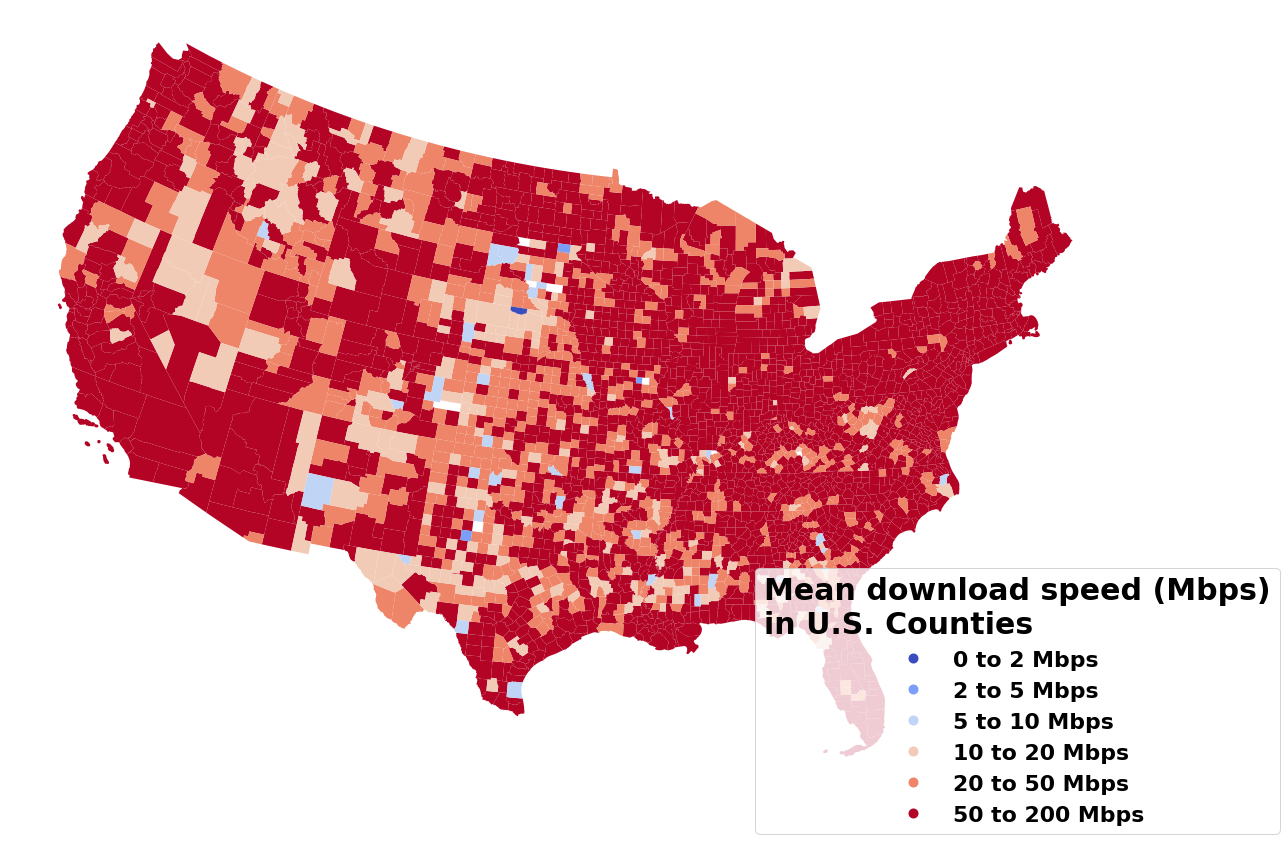

In [18]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, figsize=(20, 20))


plot_map = county_data.plot(
    column="group", cmap="coolwarm", ax=ax, legend=True
)

# ctx.add_basemap(plot_map)

ax.axis("off")
leg = ax.get_legend()
# print(leg)
leg.set_bbox_to_anchor((1.15, 0.3))
leg.set_title("Mean download speed (Mbps)\nin U.S. Counties",prop={'size':30})

# texts = []
# for x, y, label in zip(ky_places.geometry.x, ky_places.geometry.y, ky_places["NAME"]):
#     texts.append(plt.text(x, y, label, fontsize=10, fontweight="bold", ha="left"))

# adjust_text(
#     texts,
#     force_points=0.3,
#     force_text=0.8,
#     expand_points=(1, 1),
#     expand_text=(1, 1),
#     arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
# )